<h1><center>An Agent-based Economy Model</center></h1>

## Running the Agent-based Model

<span style="color:darkorange">Set the SDK path and maven repository path here.</span>

In [1]:
import json
from IPython.display import display, HTML

display(HTML("<style>.container { width:90% !important; }</style>"))
with open('notebook_settings.json', 'r') as f:
    notebook_settings = json.load(f)

FileNotFoundError: [Errno 2] No such file or directory: 'notebook_settings.json'

In [2]:
# Example of sector data
sector_data = {
    'E36': {
         'I': 319, 'N': 1860, 'alpha':0.0988, 'beta': 2.5567, 'kappa': 0.0399, 'delta': 0.0095, 'w': 0.0134,
        'tauY': 0.0071, 'tauK': 0.0266, 'bCF_g': 0, 'bCFH_g': 0, 'bHH_g': .001, 'cG_g': 0, 'cE_g': 0, 'cI_g': 0
    }
}

In [10]:
import os

from utils import *

seed = 123
level = 'WARN'
params = {
    'vm': {'seed': seed, 'runs': 1, 'ticks': 12},
#         'level': level, 'levelHH': level, 'levelFirm': level, 'levelEconomy': level},
#         'config': {'simudyne.core.export-path': 'Output_{0}'.format(seed)},
#         'input': {'G': 2, 'I': 100, 'H': 10000, 'alpha': .005, 'w': .2, 'kappa': .03, 'delta': 0.01,
#                   'wh0': 40., 'C_h_d0': 10.0, 'beta': 1.5, 'bCF_g': 0.0, 'bCFH_g': 0.0, 'bHH_g': 0.0092, 
#                   'cG_g': 0, 'cE_g': 0, 'cI_g': 0, 'a_s_g': .1, 'pi': .01},
        'notebook_settings' : notebook_settings
}

NameError: name 'notebook_settings' is not defined

In [ ]:
run_sdk(_params, notebook_settings['maven_repo'], verbose=5, debug=debug,
                                 simudyne_version='2.5.1-preview', java_cmd=notebook_settings['java_cmd'])

In [7]:
def get_error(x, i=0, seed=1234, debug=False):
    _params = {**params}
    _params['vm']['seed'] = seed
    _params['config']['simudyne.core.export-path'] = 'Output_{0}_{1}'.format(i, seed)
    _params['input'] = {**_params['input'], **x}
    if debug:
        print(x, seed)
    res, run_ids, dataset_ = run_sdk(_params, notebook_settings['maven_repo'], verbose=5, debug=debug,
                                 simudyne_version='2.5.1-preview', java_cmd=notebook_settings['java_cmd'])
    run_id = run_ids[0]
    if debug:
        print(x, seed, run_id)
        
    return res[run_id]

In [8]:
bounds = {
    'alpha': (.0055, .008)
}

In [6]:
np.random.seed(1234)

_n_pts = 6
_mc = 3
_n = _n_pts * _mc

pts = {k: np.random.uniform(bounds[k][0], bounds[k][1], _n_pts).round(6) for k in bounds}
pts = {k: np.linspace(bounds[k][0], bounds[k][1], _n_pts).round(6) for k in bounds}
_seeds = np.random.randint(0, 10000000, _mc)

X_ = [{k: pts[k][i] for k in bounds} for i in np.arange(_n_pts)]
X = [(i, j) for i in X_ for j in _seeds]

In [9]:
from joblib import Parallel, delayed
from tqdm import trange

res_ = Parallel(n_jobs=6, verbose=8)(delayed(get_error)(X[i][0], i=i, seed=X[i][1], debug=False) 
                                     for i in np.arange(len(X)))

NameError: name 'X' is not defined

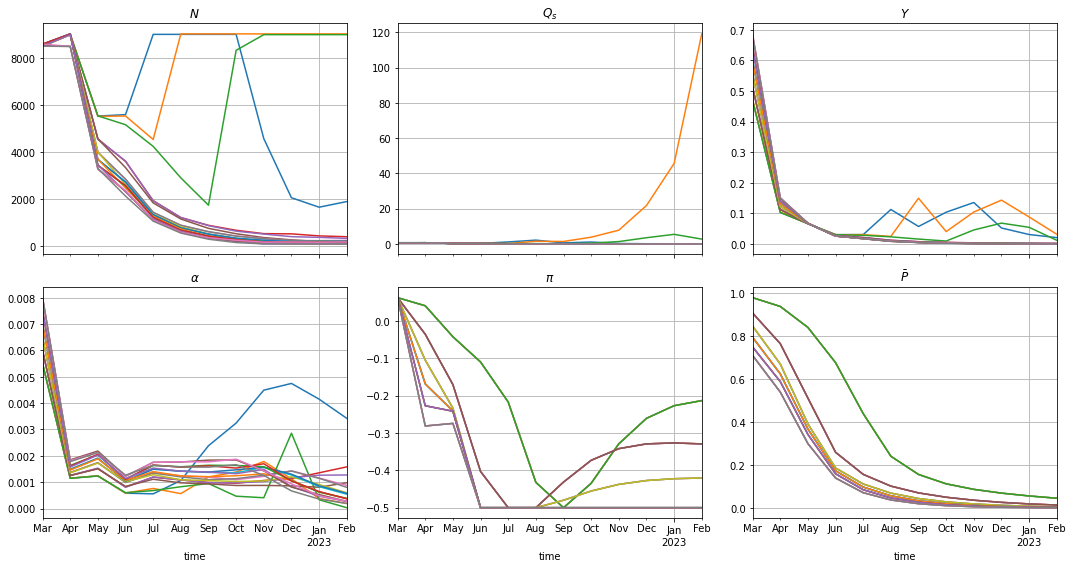

In [8]:
P = {r'$N$': pd.concat({','.join(['{0}={1}'.format(k, X[i][0][k]) for k in X[i][0]]) + ',' + str(X[i][1]): 
                        res_[i]['Firm'][['time', '_id', 'N']]
                        .set_index('time').astype(int).reset_index()
                        .pivot(index='time', columns='_id', values='N')
                        .sum(axis=1) 
           for i in np.arange(len(X))}, axis=1),
     r'$Q_s$': pd.concat({','.join(['{0}={1}'.format(k, X[i][0][k]) for k in X[i][0]]) + ',' + str(X[i][1]): 
                          res_[i]['Firm'][['time', '_id', 'Qs']]
                          .set_index('time').astype(float).reset_index()
                          .pivot(index='time', columns='_id', values='Qs')
                          .mean(axis=1) 
           for i in np.arange(len(X))}, axis=1),
     r'$Y$': pd.concat({','.join(['{0}={1}'.format(k, X[i][0][k]) for k in X[i][0]]) + ',' + str(X[i][1]): 
                        res_[i]['Firm'][['time', '_id', 'Y']]
                        .set_index('time').astype(float).reset_index()
                        .pivot(index='time', columns='_id', values='Y')
                        .mean(axis=1) 
           for i in np.arange(len(X))}, axis=1),
     r'$\alpha$': pd.concat({','.join(['{0}={1}'.format(k, X[i][0][k]) for k in X[i][0]]) + ',' + str(X[i][1]): 
                             res_[i]['Firm'][['time', '_id', 'alpha']]
                             .set_index('time').astype(float).reset_index()
                             .pivot(index='time', columns='_id', values='alpha').mean(axis=1) 
           for i in np.arange(len(X))}, axis=1),
     r'$\pi$': pd.concat({','.join(['{0}={1}'.format(k, X[i][0][k]) for k in X[i][0]]) + ',' + str(X[i][1]): 
                          res_[i]['Economy'].set_index('time')['pi']
           for i in np.arange(len(X))}, axis=1),
     r'$\bar{P}$': pd.concat({','.join(['{0}={1}'.format(k, X[i][0][k]) for k in X[i][0]]) + ',' + str(X[i][1]): 
                              res_[i]['Economy'].set_index('time')['PBar']
           for i in np.arange(len(X))}, axis=1)
    }

plot_dict_mc(P, fgs=(15, 8), legend=False)

In [9]:
W = pd.concat({k: P[k].apply(lambda i: i / i[0]).diff().std() for k in P.keys()}, axis=1)
W['seed'] = [x[1] for x in X]
for k in bounds.keys():
    W[k] = [x[0][k] for x in X]
W = W.reset_index().drop('index', axis=1).set_index(list(bounds.keys()) + ['seed']).loc[.0052:]

In [10]:
W.sample(5)

,,$N$,$Q_s$,$Y$,$\alpha$,$\pi$,$\bar{P}$
alpha,seed,,,,,,
0.0065,4759276,0.176341,0.234091,0.230878,0.240930,1.577881,0.115249
0.0070,4759276,0.186405,0.212139,0.231065,0.239906,1.586724,0.115421
0.0060,4759276,0.158327,0.255227,0.230666,0.243090,1.499978,0.105131
0.0055,4759276,0.213433,46.918444,0.267768,0.247096,1.519074,0.082309
0.0070,4005658,0.186752,0.213999,0.231029,0.239132,1.586724,0.115421


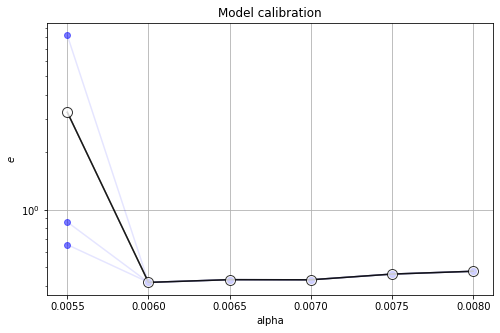

In [11]:
if len(bounds) == 1 and 'alpha' in bounds:
    for var in bounds:
        fg, ax = plt.subplots(1, 1, figsize=(8, 5))
        W.reset_index().groupby([var, 'seed']).mean().mean(axis=1).unstack().plot(ax=ax, style='-b', alpha=.1, legend=False)
        _W = W.mean(axis=1).reset_index().set_index('alpha')[0].sort_index()
        _W.plot(ax=ax, style='ob', alpha=.5, grid=True)
        __W = W.mean(axis=1).unstack().mean(axis=1)
        __W.plot(ax=ax, style='-k', grid=True, alpha=.5, logy=True)
        __W.plot(ax=ax, style='-ok', grid=True, alpha=.8, markerfacecolor='w', markeredgecolor='k', ms=10)
        ax.set_title('Model calibration')
        ax.set_ylabel(r'$e$')
        _ = ax.set_xlabel(var)
        plt.show()

In [18]:
W.mean(axis=1).unstack().mean(axis=1)

alpha
0.0055    3.241554
0.0060    0.415594
0.0065    0.429430
0.0070    0.428763
0.0075    0.459438
0.0080    0.475291
dtype: float64

In [13]:
W.swaplevel(0,1, axis=0).loc[5868625].plot()

KeyError: 5868625

In [ ]:
W.swaplevel(0,1, axis=0).loc[8331754].plot()

# Surrogate Modelling